DATA CREATION

You’ll simulate product usage + feedback to answer:

> “Why is our retention dropping, and what should we do about it?”

In [1]:
import pandas as pd
import numpy as np

np.random.seed(30)

n = 1000

df = pd.DataFrame({
    'User_ID': np.arange(1, n + 1),
    'Signup_Week': np.random.choice(range(1, 13), n),  # 12-week cohort
    'Active_Weeks': np.random.poisson(4, n),
    'Avg_Session_Length_Min': np.round(np.random.normal(12, 3, n), 1),
    'Referral': np.random.choice([0, 1], size=n, p=[0.75, 0.25]),
    'Feedback': np.random.choice([
        'Too many bugs', 'I love the app', 'Needs more features',
        'Very slow to load', 'Great for learning', 'Content is outdated',
        'Crashes often', 'Helpful interface', 'Too expensive', 'More languages please'
    ], size=n)
})

df['Churned'] = (df['Active_Weeks'] < 3).astype(int)

df.to_csv("final_retention_dataset.csv", index=False)


## Task:
1. Cohort Retention Analysis
    - Analyze churn rate by Signup_Week
    - Identify weak vs. strong signup cohorts

2. Behavioral Drivers of Churn
    - How does churn correlate with:
        - Session length
        - Referral status
        - Feedback text
    - Group feedback into themes and compare churn across themes.

3. Tell a Story (Most Important Part)
    - Use visuals + headline-style takeaways
    - Answer:
        > “Why is retention dropping, who is churning, and what should we do?”

Think like a product analyst giving a high-stakes briefing.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User_ID                 1000 non-null   int64  
 1   Signup_Week             1000 non-null   int64  
 2   Active_Weeks            1000 non-null   int32  
 3   Avg_Session_Length_Min  1000 non-null   float64
 4   Referral                1000 non-null   int64  
 5   Feedback                1000 non-null   object 
 6   Churned                 1000 non-null   int64  
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 50.9+ KB


In [3]:
df.head()

,User_ID,Signup_Week,Active_Weeks,Avg_Session_Length_Min,Referral,Feedback,Churned
0,1,6,2,0.7,0,Content is outdated,1
1,2,6,6,11.0,0,Content is outdated,0
2,3,5,4,8.7,0,Content is outdated,0
3,4,8,3,8.5,0,More languages please,0
4,5,3,2,11.9,0,More languages please,1


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

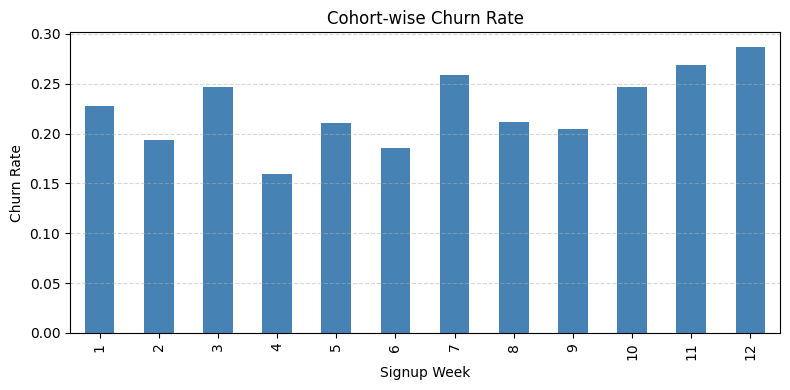

In [34]:
plt.figure(figsize=(8, 4))
df.groupby('Signup_Week')['Churned'].mean().plot(kind='bar', color='steelblue')
plt.title("Cohort-wise Churn Rate")
plt.xlabel("Signup Week")
plt.ylabel("Churn Rate")
# plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [44]:
signup_cohort = df.groupby('Signup_Week')['Churned'].mean().reset_index()
signup_cohort.rename(columns={'Churned': 'Churn_Rate'}, inplace=True)
signup_cohort.sort_values('Signup_Week', inplace=True)

In [47]:
mean_churn = signup_cohort['Churn_Rate'].mean()
std_churn = signup_cohort['Churn_Rate'].std()

print(f"Mean Churn Rate: {mean_churn:.3f}")
print(f"Std Deviation: {std_churn:.3f}")


Mean Churn Rate: 0.225
Std Deviation: 0.038


In [52]:
# Define logic: Strong = low churn, Weak = high churn
def label_cohort(churn):
    if churn > mean_churn + std_churn:
        return 'Weak'
    elif churn < mean_churn - std_churn:
        return 'Strong'
    else:
        return 'Neutral'

# Apply to each row
signup_cohort['Cohort_Type'] = signup_cohort['Churn_Rate'].apply(label_cohort)

signup_cohort

,Signup_Week,Churn_Rate,Cohort_Strength,Cohort_Type
0,1,0.227848,Neutral,Neutral
1,2,0.193548,Neutral,Neutral
2,3,0.246753,Neutral,Neutral
3,4,0.159574,Strong,Strong
4,5,0.210526,Neutral,Neutral
5,6,0.185714,Strong,Strong
6,7,0.258427,Neutral,Neutral
7,8,0.211765,Neutral,Neutral
8,9,0.204545,Neutral,Neutral
9,10,0.246753,Neutral,Neutral


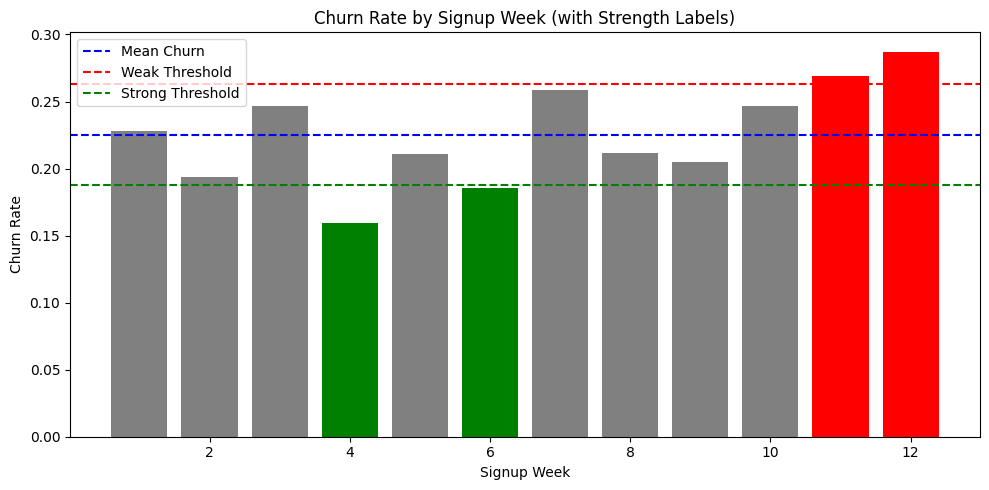

In [57]:
# Choose colors based on label
colors = signup_cohort['Cohort_Type'].map({
    'Weak': 'red',
    'Strong': 'green',
    'Neutral': 'gray'
})

# Make bar chart
plt.figure(figsize=(10, 5))
plt.bar(signup_cohort['Signup_Week'], signup_cohort['Churn_Rate'], color=colors)

# Add average lines
plt.axhline(mean_churn, linestyle='--', color='blue', label='Mean Churn')
plt.axhline(mean_churn + std_churn, linestyle='--', color='red', label='Weak Threshold')
plt.axhline(mean_churn - std_churn, linestyle='--', color='green', label='Strong Threshold')

plt.title("Churn Rate by Signup Week (with Strength Labels)")
plt.xlabel("Signup Week")
plt.ylabel("Churn Rate")
plt.legend()
plt.tight_layout()
plt.show()


In [60]:
df['Feedback'].unique()

array(['Content is outdated', 'More languages please',
       'Very slow to load', 'Needs more features', 'Great for learning',
       'I love the app', 'Too expensive', 'Too many bugs',
       'Helpful interface', 'Crashes often'], dtype=object)

In [101]:
# As the feature has limited words we can use bucketing other wise we have to use NLP techniques

theme_map = {
    'Too many bugs': 'Bugs and Crashes',
    'Crashes often': 'Bugs and Crashes',
    'Very slow to load': 'Performance',
    'Content is outdated': 'Content',
    'Needs more features': 'Feature Requests',
    'More languages please': 'Feature Requests',
    'Too expensive': 'Pricing',
    'I love the app': 'Positive',
    'Great for learning': 'Positive',
    'Helpful interface': 'Positive'
}

df['Feedback_Theme'] = df['Feedback'].map(theme_map)


In [59]:
df.head()

,User_ID,Signup_Week,Active_Weeks,Avg_Session_Length_Min,Referral,Feedback,Churned,Feedback_Theme
0,1,6,2,0.7,0,Content is outdated,1,Other
1,2,6,6,11.0,0,Content is outdated,0,Other
2,3,5,4,8.7,0,Content is outdated,0,Other
3,4,8,3,8.5,0,More languages please,0,Missing Features
4,5,3,2,11.9,0,More languages please,1,Missing Features


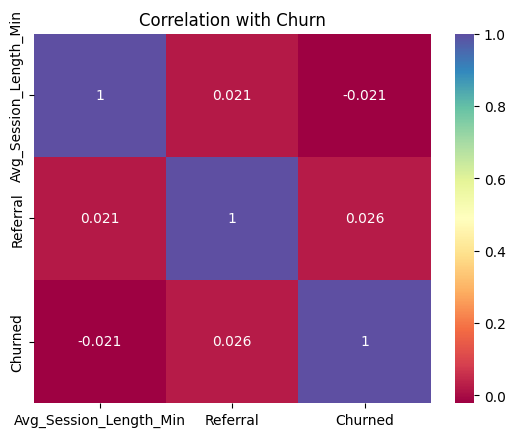

In [79]:
df_corr = df[['Avg_Session_Length_Min', 'Referral', 'Churned']]

sns.heatmap(data=df_corr.corr(), annot=True, cmap='Spectral')
plt.title("Correlation with Churn")
plt.show()

In [88]:
df_corr.corr()['Churned'].sort_values(ascending=False)

Churned                   1.000000
Referral                  0.026245
Avg_Session_Length_Min   -0.021224
Name: Churned, dtype: float64

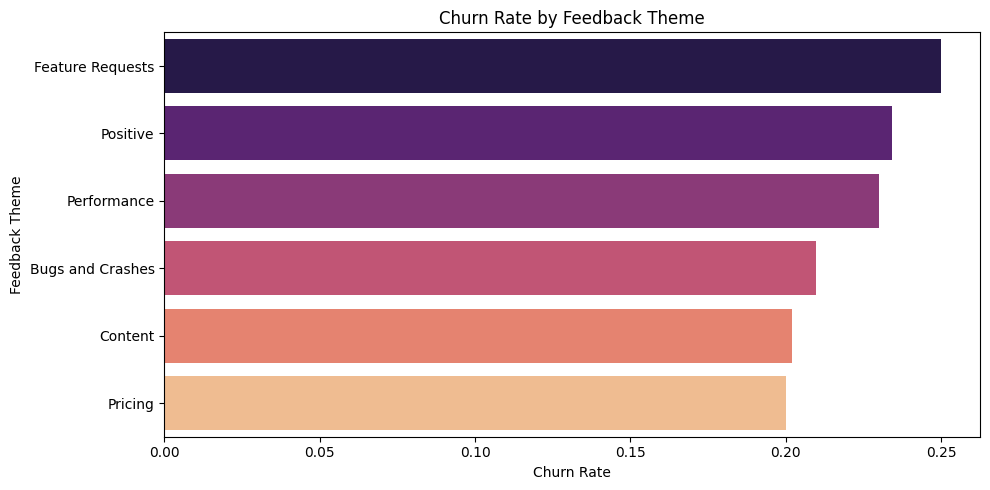

In [102]:
# Average churn rate by theme
theme_churn = df.groupby('Feedback_Theme')['Churned'].mean().reset_index()
theme_churn.sort_values('Churned', ascending=False, inplace=True)

# Bar plot
plt.figure(figsize=(10,5))
sns.barplot(data=theme_churn, x='Churned', y='Feedback_Theme',hue='Feedback_Theme', palette='magma', legend=False)
# sns.barplot(data=theme_churn, x='Feedback_Theme', y='Churned',hue='Churned', palette='magma', legend=False)
plt.title("Churn Rate by Feedback Theme")
plt.xlabel("Churn Rate")
plt.ylabel("Feedback Theme")
plt.tight_layout()
plt.show()


In [89]:
df['Churned'].mean()

np.float64(0.225)

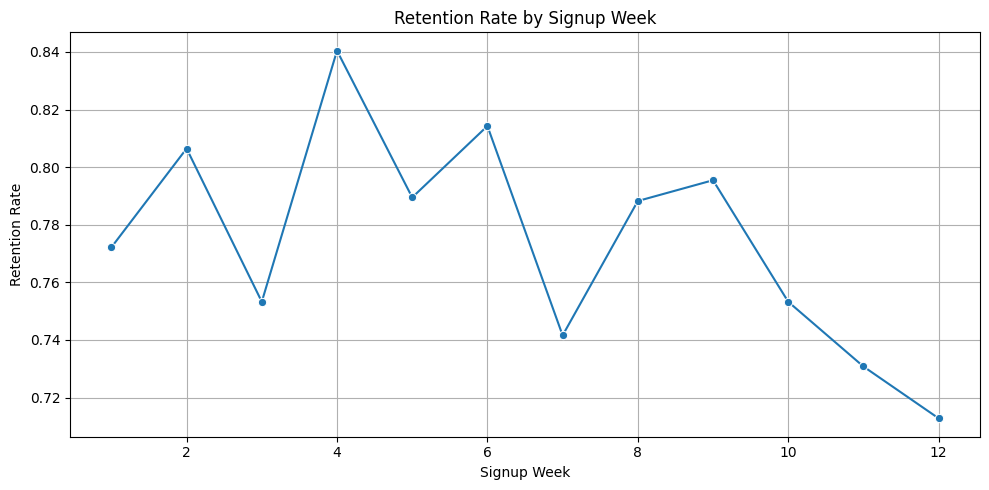

In [92]:
df['Retained'] = 1 - df['Churned']
retention_by_week = df.groupby('Signup_Week')['Retained'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=retention_by_week, x='Signup_Week', y='Retained', marker='o')
plt.title("Retention Rate by Signup Week")
plt.xlabel("Signup Week")
plt.ylabel("Retention Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

In [111]:
df.groupby('Signup_Week')['Retained'].mean() * 100

Signup_Week
1     77.215190
2     80.645161
3     75.324675
4     84.042553
5     78.947368
6     81.428571
7     74.157303
8     78.823529
9     79.545455
10    75.324675
11    73.076923
12    71.276596
Name: Retained, dtype: float64